In [114]:
import numpy
import math
import random
from graphviz import Digraph

In [115]:
#engine

class Value:

    def __init__(self,data,op='',children=(),label=''):
        self.data=data
        self.label=label
        self.op=op
        self.prev=set(children) 
        self.grad=0
        self._backward=lambda: None

        
    def __repr__(self):
        return f"Value(data={self.data},label={self.label},op={self.op},grad={self.grad})"
    
    #############

    def __add__(self,other):
        #print("add")
        other=other if isinstance(other, (Value)) else Value(other)
        out=Value(self.data+other.data,'+',(self,other))
        def _backward():
            self.grad+=1*out.grad
            other.grad+=1*out.grad
        out._backward=_backward
        return out
    
    def __mul__(self,other):
        #print("mul")
        other=other if isinstance(other, (Value)) else Value(other)
        out=Value(self.data*other.data,'*',(self,other))
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    
    def __pow__(self,other):
        #print("pow")
        assert isinstance(other,(int,float)),"not defined"
        out=Value(self.data**other,f'**{other}',(self,))
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward
        return out
    
    ############

    def relu(self):
        #print("relu")
        out=Value(0 if self.data<=0 else self.data, 'relu', (self,)) 
        def _backward():
            self.grad+=(0 if self.data<=0 else 1)*out.grad
        out._backward=_backward
        return out

    def tanh(self):
        #print("tanh")
        t=math.tanh(self.data)
        out=Value(t,'tanh',(self,))
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    
    #############

    def __radd__(self,other):
        #print("radd")
        return self+other
    
    def __neg__(self):
        #print("neg")
        return self*-1

    def __sub__(self,other):
        #print("sub")
        return self+(-other)
    
    def __rsub__(self,other):
        #print("rsub")
        return (-self)+other
    
    def __rmul__(self,other):
        #print("rmul")
        return self*other
    
    def __truediv__(self,other):
        #print("truediv")
        return self*(other**-1)
    
    def __rtruediv__(self,other):
        return self**-1*other
    
    ############

    def backward(self):
        topo=[]
        visited=set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for node in v.prev:
                    build_topo(node)
                topo.append(v)
        build_topo(self)

        self.grad=1
        for n in reversed(topo):
            n._backward()


In [127]:
def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot=Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes,edges=trace(root)

    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label="{%s|data %.4f|grad %.4f}" %(n.label,n.data,n.grad), shape='record')

        if n.op:
            dot.node(name=uid+n.op,label=n.op)
            dot.edge(uid+n.op,uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2.op)

    return dot

In [128]:
class Neuron:

    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self, x):
        linear_op=sum([self.w[i]*x[i] for i in range(len(self.w))]+[self.b])
        return linear_op.relu()



class Layer:

    def __init__(self,prev_layer_size,current_layer_size):
        self.neurons=[Neuron(prev_layer_size) for _ in range(current_layer_size)]

    def __call__(self,x):
        out=[n(x) for n in self.neurons]
        return out[0] if len(out)==1 else out


class MLP:

    def __init__(self, input_size, inner_layer_sizes):
        layer_sizes=[input_size]+inner_layer_sizes
        self.layers=[Layer(layer_sizes[i],layer_sizes[i+1]) for i in range(len(inner_layer_sizes))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x

In [129]:
model=MLP(4,[6,6,1])

In [130]:
x=[1,2,3,4]

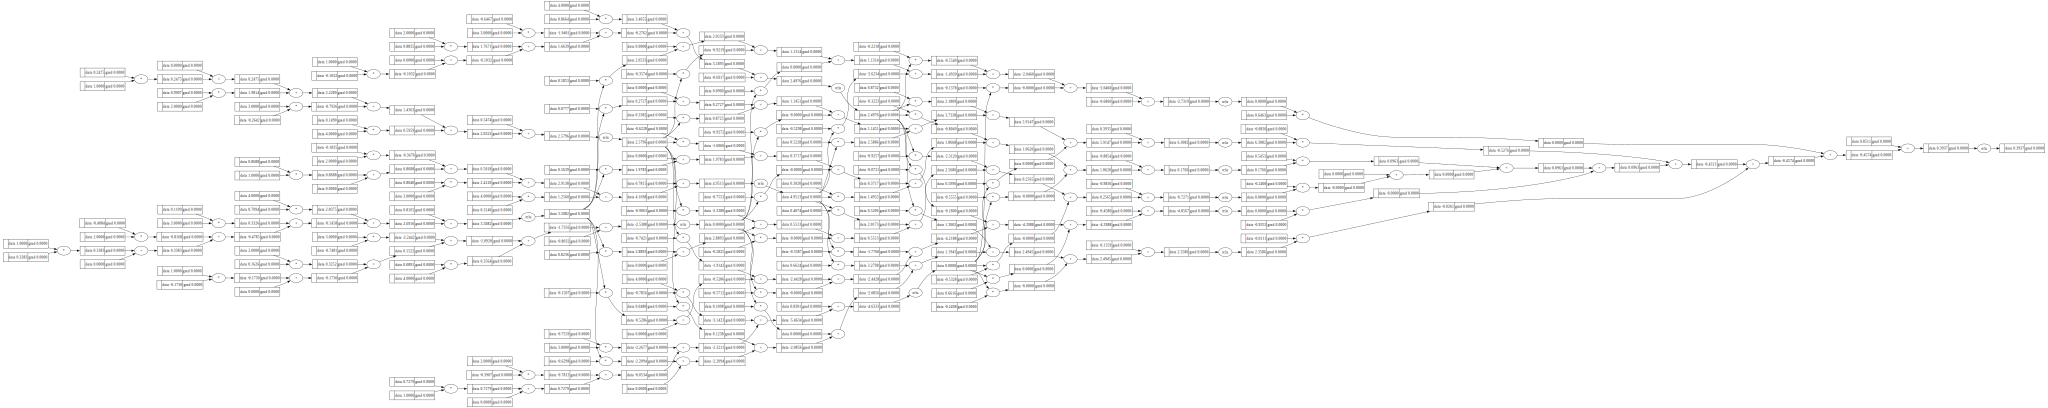

In [131]:
draw_dot(model(x))